## In this notebook  

This notebook provides an  example of using the pymsm package in a more complex setting which includes recurring ecents and time-varying covariates.  
We will also see how to load a saved model and run simualtions.  
For all this, we will use Israel COVID-19 hospitalization [public data](https://github.com/JonathanSomer/covid-19-multi-state-model/blob/master/data/data_for_paper.csv), as described in [Roimi et. al. 2021](https://academic.oup.com/jamia/article/28/6/1188/6105188).  

In [50]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsm.datasets import prep_covid_hosp_data
from pymsm.multi_state_competing_risks_model import MultiStateModel
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    get_path_frequencies,
    path_total_time_at_states
)
from pymsm.simulation import MultiStateSimulator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [51]:
from pymsm.datasets import prep_covid_hosp_data, plot_covid_hosp
dataset, state_labels = prep_covid_hosp_data()
plot_covid_hosp(dataset, state_labels)


100%|██████████| 2675/2675 [00:09<00:00, 291.44it/s]


In [52]:
# Some definitions
covariate_cols = ["is_male", "age", "was_severe"]
terminal_states = [4]
state_labels_short = {0: "C", 1: "R", 2: "M", 3: "S", 4: "D"}
print(state_labels)


{1: 'Discharged\\Recovered', 2: 'Mild or Moderate', 3: 'Severe', 4: 'Deceased'}


Let's look at one patients path

In [53]:
dataset[567].print_path()

Sample id: 577
States: [2 3 4]
Transition times: [ 6 31]
Covariates:
is_male        1.0
age           72.5
was_severe     0.0
Name: 567, dtype: float64


For the example above, we see a man aged 72.5,  
who follows a path of "Mild or Moderate"->"Severe"->"Deceased"  
with transition times of 6 and 31 days.

## Path frequencies  

We can print out a summary for all different trajectories in the data

In [54]:
path_freqs = get_path_frequencies(dataset, state_labels_short)
print(path_freqs)

M->R                               1906
M                                   202
M->S                                 76
S->D                                 74
M->S->D                              59
M->S->M->R                           46
M->D                                 44
M->R->M->R                           42
S                                    42
M->R->M                              36
M->S->M                              35
S->M->R                              28
S->M                                 27
M->S->M->S                            8
S->R                                  6
S->M->S                               5
S->M->S->M->R                         3
S->M->D                               3
M->S->M->S->M                         3
M->S->M->S->M->R                      3
M->R->M->R->M->R                      3
M->S->R                               3
S->M->S->D                            2
M->S->M->D                            2
M->R->M->S                            2


## Define time-varying covariates  

We can define a custom "update_covariates_function" such as below: 

In [55]:
def covid_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    covariates = covariates_entering_origin_state.copy()

    # update is_severe covariate
    if origin_state == 3:
        covariates['was_severe'] = 1

    # # update cum_hosp_tim covariate
    # if ((origin_state==2) & (origin_state==3)):
    #     covariates["cum_hosp_time"] += time_at_origin

    return covariates

## Fitting the Multistate model

In [56]:
multi_state_model = MultiStateModel(
    dataset=dataset,
    terminal_states=terminal_states,
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
    state_labels=state_labels,
)

In [7]:
multi_state_model.fit()


Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
>>> Fitting Transition to State: 3, n events: 2


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column is_male have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'is_male'].var())
>>> print(df.loc[~events, 'is_male'].var())

A very low variance means that the column is_male completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.537. This may imply non-unique solutions to the maximum likelihood. Perha

Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193
>>> Fitting Transition to State: 1, n events: 9
>>> Fitting Transition to State: 4, n events: 135


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column was_severe have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'was_severe'].var())
>>> print(df.loc[~events, 'was_severe'].var())

A very low variance means that the column was_severe completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.262. This may imply non-unique solutions to the maximum likel

In [58]:
multi_state_model.transition_table()

target_state,Censored,Discharged\Recovered,Mild or Moderate,Severe,Deceased
origin_state,,,,,
Discharged\Recovered,2044,0,98,2,0
Mild or Moderate,309,2135,0,275,52
Severe,135,9,193,0,135


Note that we get some warnings for some of the transitions. These should be handled or at least acknowledged when fitting a model.  
Another option might be to discard these transitions that contain a small nuber of sample. We can set the `trim_transitions_threshold` to a minimal nuber of samples for which a model will be trained.  
Let's set this to 10 below

## Trimming transitions

In [59]:
multi_state_model = MultiStateModel(
    dataset=dataset,
    terminal_states=terminal_states,
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
    state_labels=state_labels,
    trim_transitions_threshold=10
)

In [40]:
multi_state_model.fit()

Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193
>>> Fitting Transition to State: 4, n events: 135


In [61]:
multi_state_model.transition_table()

target_state,Censored,Discharged\Recovered,Mild or Moderate,Severe,Deceased
origin_state,,,,,
Discharged\Recovered,2044,0,98,0,0
Mild or Moderate,309,2135,0,275,52
Severe,135,0,193,0,135


## Single patient stats  
Let's take a look at how the model models transitions for a single patient - a female aged 75  
We'll run a Monte-Carlo simulation for 100 samples and present some path statistics

In [41]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe":0}),
    origin_state=2,
    current_time=0,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

 32%|███▏      | 32/100 [00:16<00:43,  1.56it/s]/home/hagair/repo/pymsm/src/pymsm/multi_state_competing_risks_model.py:594: RuntimeWarning: invalid value encountered in true_divide
  probability_for_each_t / probability_for_each_t.max()
 56%|█████▌    | 56/100 [00:33<00:29,  1.48it/s]/home/hagair/repo/pymsm/src/pymsm/multi_state_competing_risks_model.py:594: RuntimeWarning: invalid value encountered in true_divide
  probability_for_each_t / probability_for_each_t.max()
 80%|████████  | 80/100 [00:49<00:13,  1.43it/s]/home/hagair/repo/pymsm/src/pymsm/multi_state_competing_risks_model.py:594: RuntimeWarning: invalid value encountered in true_divide
  probability_for_each_t / probability_for_each_t.max()
100%|██████████| 100/100 [01:01<00:00,  1.61it/s]
/home/hagair/repo/pymsm/src/pymsm/multi_state_competing_risks_model.py:594: RuntimeWarning: invalid value encountered in true_divide
  probability_for_each_t / probability_for_each_t.max()


Let's calculate the probability of being in any of the states and also obtain stats regarding time in each state

In [42]:
# Probability of visiting any of the states
for state, state_label in state_labels.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in state_labels.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T


Probabilty of ever being Discharged\Recovered = 0.09
Probabilty of ever being Mild or Moderate = 1.0
Probabilty of ever being Severe = 0.24
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,3.970,4.070,0.470
time_in_state_std,14.983,2.507,1.253
time_in_state_median,0.000,4.000,0.000
time_in_state_min,0.000,1.000,0.000
time_in_state_max,96.000,18.000,7.000
time_in_state_quantile_0.1,0.000,2.000,0.000
time_in_state_quantile_0.25,0.000,3.000,0.000
time_in_state_quantile_0.75,0.000,5.000,0.000
time_in_state_quantile_0.9,0.000,7.000,2.000


Print out the path frequences for the sampled paths

In [43]:
path_freqs = get_path_frequencies(mc_paths, state_labels)
path_freqs.head(10)

Mild or Moderate->Deceased                                             67
Mild or Moderate->Severe->Deceased                                     24
Mild or Moderate->Discharged\\Recovered->Mild or Moderate->Deceased     9
dtype: int64

A CDF for the total time in hospital

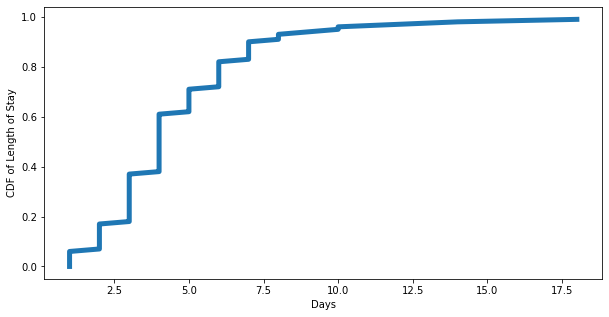

In [44]:
los = np.array([path_total_time_at_states(path, states = [2,3]) for path in mc_paths])

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(np.sort(los), np.linspace(0, 1, len(los), endpoint=False), lw=5)
# ax.set_xlim(0,20)
ax.set_ylabel('CDF of Length of Stay')
ax.set_xlabel('Days');

We can also look at Monte-Carlo simulations for the same patient, assuming we already know she has been in the Severe (3) state, for 2 days.

To do this, we simply need to set the *origin_state* to 3, set the *current_time* to 2, and update her covariates accordingly.

In [45]:
# Run MC for a sample single patient
mc_paths_severe = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 1}),
    origin_state=3,
    current_time=2,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]
/home/hagair/repo/pymsm/src/pymsm/multi_state_competing_risks_model.py:594: RuntimeWarning: invalid value encountered in true_divide
  probability_for_each_t / probability_for_each_t.max()


Now we can calculate the probability of being in any of the states and obtain stats regarding time in each state.

We can compare these to the statistics we obtained above, when the patient started in a Mild (2) state.

In [46]:
# Probability of visiting any of the states
for state, state_label in state_labels.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths_severe, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in state_labels.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths_severe, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T

Probabilty of ever being Discharged\Recovered = 0.0
Probabilty of ever being Mild or Moderate = 0.11
Probabilty of ever being Severe = 1.0
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,0.0,0.100,8.570
time_in_state_std,0.0,0.458,10.872
time_in_state_median,0.0,0.000,5.000
time_in_state_min,0.0,0.000,0.000
time_in_state_max,0.0,3.000,83.000
time_in_state_quantile_0.1,0.0,0.000,0.000
time_in_state_quantile_0.25,0.0,0.000,2.750
time_in_state_quantile_0.75,0.0,0.000,10.000
time_in_state_quantile_0.9,0.0,0.000,19.000


## Saving the model and configuring a simulator  
We can save the model for later use, and configure a simulator to generate simulated paths

In [47]:
from pymsm.simulation import extract_competing_risks_models_list_from_msm

competing_risks_models_list = extract_competing_risks_models_list_from_msm(
    multi_state_model, verbose=True
)

# Configure the simulator
mssim = MultiStateSimulator(
    competing_risks_models_list,
    terminal_states=[5, 6],
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
    state_labels=state_labels,
)


2 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f279807b3d0>
2 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f2798071280>
2 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f279807bf10>
1 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f2799dd9dc0>
3 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f27d41c56d0>
3 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f27d7a33fa0>


And now we can sample paths from this simulator  

In [48]:
# Run MC for a sample single patient
sim_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe": 0}),
    origin_state=3,
    current_time=2,
    n_random_samples=5,
    max_transitions=10,
    print_paths=True,
    n_jobs=-1
)

100%|██████████| 5/5 [00:00<00:00, 1717.99it/s]


States: [3, 4]
Transition times: [7.455064368055986e-06]


States: [3, 4]
Transition times: [5.683086033370088e-05]


States: [3, 4]
Transition times: [1.0000540635121609]


States: [3, 4]
Transition times: [5.76903884628166e-05]


States: [3, 4]
Transition times: [3.2004960103027e-05]


